<a href="https://colab.research.google.com/github/rokmr/PyTorch/blob/main/Fine_Tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fine tuning: Replace the ImageNet trained classifier in ResNet-18 with a new classifier for the given dataset. Fine-tune only the classification layer using the training data given (and additional data if you want) and report the performance on test data

# Importing required Library

In [86]:
%matplotlib inline

In [87]:
import torch
import torchvision
from torch import nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
from tqdm.auto import tqdm

import numpy as np
from matplotlib import pyplot as plt
import os                                                  
from typing import Dict, List, Tuple                        # Used for specifying output type

# Device Agnostic and Data prepration 

In [88]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
from pathlib import Path
data_dir = Path('/content/drive/Shareddrives/Python Basics/AIP_Assignment/A1/classification_dataset')

train_dir = data_dir / 'train'
test_dir = data_dir / 'test'

In [91]:
data_transforms = {
    # Data transforamtio for training data

    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    # Data transforamtio for testing data

    'test': transforms.Compose([
        transforms.Resize(226),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [92]:
NUM_WORKERS = os.cpu_count()                     # if there is more than 1 number of cpu is available 

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    transform: transforms.Compose, 
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=data_transforms["train"])
  test_data = datasets.ImageFolder(test_dir, transform=data_transforms["test"])

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,                                 # Suffling the data for training mode 
      num_workers=num_workers,                      
      pin_memory=True,                              # Enables fast data transfer to CUDA-enabled GPUs in multi- processing
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,                                 # no Suffling the data for testing mode
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names, len(train_data), len(test_data)


In [93]:
train_dataloader, test_dataloader, class_names, train_data_num, test_data_num = create_dataloaders(train_dir= train_dir, 
                                                                                                      test_dir= test_dir, 
                                                                                                      transform= data_transforms, 
                                                                                                      batch_size= 32, 
                                                                                                      num_workers= NUM_WORKERS)

In [94]:
print(class_names)
print(f"Number of train data: {train_data_num}")
print(f"Number of test data: {test_data_num}")

['bear', 'butterfly', 'camel', 'chimp', 'duck', 'elephant']
Number of train data: 532
Number of test data: 120


# Model and Changing its classifier

In [95]:
model_ft = models.resnet18(pretrained=True).to(device)

print(model_ft.fc)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=512, out_features=1000, bias=True)


In [96]:
# !pip install -q torchinfo
# from torchinfo import summary
# summary(model=model_ft,
#         input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [97]:
# Changing fc layer
in_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(in_features=in_features, out_features=len(class_names)).to(device) # len(class_names) will provide number of input
for params in model_ft.parameters():
  params.requires_grad_(False)
     
for params in model_ft.fc.parameters():
  params.requires_grad_(True)
model_ft.fc 

Linear(in_features=512, out_features=6, bias=True)

In [98]:
# summary(model=model_ft,
#         input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

# Training and Testing of modal

## Setting up function for Training

> Indented block



In [99]:
# Setting-up train-step function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
              #  scheduler,
               accuracy_fn,
               device: torch.device = device):
  """Performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  model.train()                                        # Put model into training mode

  for batch, (X, y) in enumerate(data_loader):         # Add a loop to loop through the training batches
    X, y = X.to(device), y.to(device)

    y_pred = model(X)                                  # getting Prediction

    loss = loss_fn(y_pred, y)                          # Loss Calculation
    train_loss += loss                                 # accumulate train loss

    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)  # go from logits -> prediction labels
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # scheduler.step()
  # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  # print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc*100:.2f}%")
  return train_loss, train_acc


# Setting-up tesp-step function
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0
  
  model.eval()                     # Put the model in eval mode (indicates the model that nothing new is to be learnt)

  with torch.inference_mode():     # Turn on inference mode context manager (locally disable grad)
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      test_pred = model(X)         # logits

      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(test_pred.argmax(dim=1), y)     # go from logits -> prediction labels 

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    # print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc*100:.2f}%\n")
    return test_loss, test_acc

In [100]:
# Setting-up training loop 
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          # scheduler,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }
    
    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          data_loader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          # scheduler=scheduler,
                                          accuracy_fn=accuracy_fn,
                                          device=device)
        
        test_loss, test_acc = test_step(model=model,
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc*100:.2f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc*100:.2f}"
        )

        # Update results dictionary which will be used for plotting
        results["train_loss"].append(train_loss.detach().cpu().numpy())
        results["train_acc"].append(train_acc.detach().cpu().numpy())
        results["test_loss"].append(test_loss.detach().cpu().numpy())
        results["test_acc"].append(test_acc.detach().cpu().numpy())

    # Return the filled results at the end of the epochs
    return results

## Training

In [101]:
# Hyper Parametr
EPOCHS = 20
LR = 0.001

optimizer = torch.optim.Adam(model_ft.fc.parameters(), lr=LR)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1) 

# Seting-up loss and optimizer
loss_fn = nn.CrossEntropyLoss()

In [102]:
!pip install torchmetrics
from torchmetrics import Accuracy, ConfusionMatrix

#Parameters Measure
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [103]:
# Getting result of training 
result = train(model=model_ft,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
              #  scheduler=exp_lr_scheduler,
               loss_fn=loss_fn,
               epochs=EPOCHS,
               device=device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.5848 | train_acc: 37.21 | test_loss: 1.0130 | test_acc: 77.86
Epoch: 2 | train_loss: 1.0079 | train_acc: 72.43 | test_loss: 0.6611 | test_acc: 85.94
Epoch: 3 | train_loss: 0.7191 | train_acc: 83.79 | test_loss: 0.4096 | test_acc: 96.09
Epoch: 4 | train_loss: 0.5653 | train_acc: 86.76 | test_loss: 0.3277 | test_acc: 95.83
Epoch: 5 | train_loss: 0.4626 | train_acc: 89.30 | test_loss: 0.2673 | test_acc: 96.88
Epoch: 6 | train_loss: 0.4066 | train_acc: 91.03 | test_loss: 0.2420 | test_acc: 96.88
Epoch: 7 | train_loss: 0.3876 | train_acc: 90.00 | test_loss: 0.2043 | test_acc: 96.09
Epoch: 8 | train_loss: 0.3437 | train_acc: 92.17 | test_loss: 0.2032 | test_acc: 96.88
Epoch: 9 | train_loss: 0.3481 | train_acc: 89.96 | test_loss: 0.1819 | test_acc: 96.88
Epoch: 10 | train_loss: 0.3136 | train_acc: 91.07 | test_loss: 0.1629 | test_acc: 96.88
Epoch: 11 | train_loss: 0.3254 | train_acc: 89.34 | test_loss: 0.1590 | test_acc: 96.09
Epoch: 12 | train_loss: 0.3496 | train_ac

## Ploting the output

In [104]:
def plot_loss_curves(results):
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

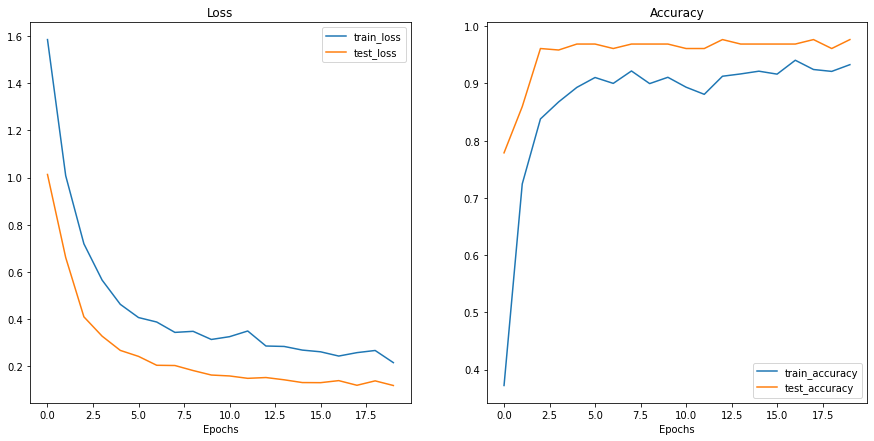

In [105]:
plot_loss_curves(result)

# Measures

In [106]:
model_ft.eval()                     # Put the model in eval mode (indicates the model that nothing new is to be learnt)
test_data = datasets.ImageFolder(test_dir, transform=data_transforms["test"])
test_dataloader_metric = DataLoader(test_data,
      batch_size=120,
      shuffle=False)                                 # no Suffling the data for testing mode)
with torch.inference_mode():     # Turn on inference mode context manager (locally disable grad)
  for X, y in test_dataloader_metric:
      X, y = X.to(device), y.to(device)
      test_pred = model_ft(X)
y_pred =test_pred.argmax(dim=1)    

In [108]:
# Confusion Matrix
conf_mat = confmat(y_pred, y)
acc_perct = accuracy_fn(y_pred, y) * 100
print(f"Accuracy percentage : {acc_perct:.3f}")
print("----------------------------------")
print("Confusion Matrix")
print(conf_mat)

Accuracy percentage : 97.500
----------------------------------
Confusion Matrix
tensor([[18,  0,  0,  2,  0,  0],
        [ 0, 20,  0,  0,  0,  0],
        [ 0,  0, 20,  0,  0,  0],
        [ 0,  0,  0, 20,  0,  0],
        [ 0,  0,  0,  0, 19,  1],
        [ 0,  0,  0,  0,  0, 20]], device='cuda:0')
